# Replacing Covid Tracking Project - Simplified Workflow

>NOTE: ~~See  final workflow in the final script: `data_acquisition.py`~~ **as of 08/12, the development of the data acquisition code has moved back to "`Exploring Options for Replacing Covid Tracking Project Data_08-2021.ipynb`"**

- 08/09/21

- This is a companion notebook to `Exploring Options for Replacing Covid Tracking Project Data_08-2021`
- The goal is to only save the final pieces of code required to produce the dataset, and to exclude testing things out and info displays

## Summary

- Download kaggle data for the deaths and cases counts
- Download Socrata HHS data for hospital info
- Get all as daily frequency and with State Abbrevs before merging

# Data

In [81]:
# !pip install -U fsds
from fsds.imports import *

import os,zipfile,json
pd.set_option('display.max_columns',0)

In [31]:
## Appending folder with functions
%load_ext autoreload 
%autoreload 2
# import sys
# sys.path.append('.')

import functions as fn
# help(fn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Specifying File Destinations

In [32]:
## Make a dict of desired filenames for final csvs

file_dict = {
    "state metadata":"./data/state_metadata.csv",
    "state deaths":"./data/state_deaths.csv",
     "state cases":"./data/state_confirmed_cases.csv",
}

import json
with open("FILENAMES.json",'w') as f:
    json.dump(file_dict,f)

In [33]:
with open("FILENAMES.json",'r') as f:
    file_dict = json.load(f)
file_dict

{'state metadata': './data/state_metadata.csv',
 'state deaths': './data/state_deaths.csv',
 'state cases': './data/state_confirmed_cases.csv'}

## Loading in Reference Table for State Names

In [34]:
## Getting State Abbrevs
state_abbrevs = pd.read_csv('Reference Data/united_states_abbreviations.csv')

## Making dicts of Name:Abbrev and Abbrev:Name
state_to_abbrevs_map = dict(zip(state_abbrevs['State'],state_abbrevs['Abbreviation']))
abbrev_to_state_map = dict(zip(state_abbrevs['Abbreviation'],state_abbrevs['State']))
state_to_abbrevs_map

{'Alabama': 'AL',
 'Alaska': 'AK',
 'Arizona': 'AZ',
 'Arkansas': 'AR',
 'California': 'CA',
 'Colorado': 'CO',
 'Connecticut': 'CT',
 'Delaware': 'DE',
 'District of Columbia': 'DC',
 'Florida': 'FL',
 'Georgia': 'GA',
 'Hawaii': 'HI',
 'Idaho': 'ID',
 'Illinois': 'IL',
 'Indiana': 'IN',
 'Iowa': 'IA',
 'Kansas': 'KS',
 'Kentucky': 'KY',
 'Louisiana': 'LA',
 'Maine': 'ME',
 'Montana': 'MT',
 'Nebraska': 'NE',
 'Nevada': 'NV',
 'New Hampshire': 'NH',
 'New Jersey': 'NJ',
 'New Mexico': 'NM',
 'New York': 'NY',
 'North Carolina': 'NC',
 'North Dakota': 'ND',
 'Ohio': 'OH',
 'Oklahoma': 'OK',
 'Oregon': 'OR',
 'Maryland': 'MD',
 'Massachusetts': 'MA',
 'Michigan': 'MI',
 'Minnesota': 'MN',
 'Mississippi': 'MS',
 'Missouri': 'MO',
 'Pennsylvania': 'PA',
 'Rhode Island': 'RI',
 'South Carolina': 'SC',
 'South Dakota': 'SD',
 'Tennessee': 'TN',
 'Texas': 'TX',
 'Utah': 'UT',
 'Vermont': 'VT',
 'Virginia': 'VA',
 'Washington': 'WA',
 'West Virginia': 'WV',
 'Wisconsin': 'WI',
 'Wyoming': 'WY

## Covid-19 Data From Johns Hopkins University

- https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university
- Comes with CONVENIENT_ files and RAW_ files.

In [35]:
## Download zipfile
!kaggle datasets download -d antgoldbloom/covid19-data-from-john-hopkins-university

jhu_data_zip = zipfile.ZipFile('covid19-data-from-john-hopkins-university.zip')
jhu_data_zip.namelist()

covid19-data-from-john-hopkins-university.zip: Skipping, found more recently modified local copy (use --force to force download)


['CONVENIENT_global_confirmed_cases.csv',
 'CONVENIENT_global_deaths.csv',
 'CONVENIENT_global_metadata.csv',
 'CONVENIENT_us_confirmed_cases.csv',
 'CONVENIENT_us_deaths.csv',
 'CONVENIENT_us_metadata.csv',
 'RAW_global_confirmed_cases.csv',
 'RAW_global_deaths.csv',
 'RAW_us_confirmed_cases.csv',
 'RAW_us_deaths.csv']

### prep `df_metadata`

In [36]:
# metadata
file = 'CONVENIENT_us_metadata.csv'
jhu_data_zip.extract(file)
df_metadata = pd.read_csv(file)
df_metadata['State_Code'] = df_metadata['Province_State'].map(state_to_abbrevs_map)
df_metadata.to_csv(file_dict['state metadata'])
df_metadata.head()

,Province_State,Admin2,Population,Lat,Long,State_Code
0,Alabama,Autauga,55869,32.539527,-86.644082,AL
1,Alabama,Baldwin,223234,30.727750,-87.722071,AL
2,Alabama,Barbour,24686,31.868263,-85.387129,AL
3,Alabama,Bibb,22394,32.996421,-87.125115,AL
4,Alabama,Blount,57826,33.982109,-86.567906,AL


### Prep ` df_cases_ts`

#### Functionizing Cases Processing

In [38]:
def load_df_cases_ts(df_cases, id_cols = ['Province_State',"State_Code",'Admin2'],
                      var_name='date',value_name='# Cases',
                     cols_to_drop=['iso2','iso3','code3','UID',
                                   'Country_Region','Combined_Key',
                                   'Lat','Long_','FIPS']):
    
    value_cols = [c for c in df_cases.columns if c not in [*cols_to_drop,*id_cols]]
    
    df_cases_ts = pd.melt(df_cases, 
                          id_vars=id_cols, value_vars=value_cols,
                          var_name=var_name, value_name=value_name)
    
    df_cases_ts['date'] = pd.to_datetime(df_cases_ts['date'])
    df_cases_ts = df_cases_ts.set_index(['State_Code','date']).sort_index()
    return df_cases_ts

In [39]:
##  Prep Cases
file = 'RAW_us_confirmed_cases.csv'
jhu_data_zip.extract(file)

df_cases = pd.read_csv(file)
## Mapping State Abbrevs and Only Keep Matched States
df_cases['State_Code'] = df_cases['Province_State'].map(state_to_abbrevs_map)
df_cases = df_cases[df_cases['Province_State'].isin(state_abbrevs['State'])]

df_cases_ts = load_df_cases_ts(df_cases)
df_cases_ts

Province_State          Admin2  # Cases
State_Code date                                              
AK         2020-01-22         Alaska  Aleutians East        0
           2020-01-22         Alaska  Aleutians West        0
           2020-01-22         Alaska       Anchorage        0
           2020-01-22         Alaska          Bethel        0
           2020-01-22         Alaska     Bristol Bay        0
...                              ...             ...      ...
WY         2021-08-08        Wyoming           Teton     3960
           2021-08-08        Wyoming           Uinta     2498
           2021-08-08        Wyoming      Unassigned        0
           2021-08-08        Wyoming        Washakie      950
           2021-08-08        Wyoming          Weston      694

[1884840 rows x 3 columns]

### Prep ` df_deaths_ts`

#### Functionizing Deaths Processing

In [40]:
def load_df_deaths_ts(df_deaths, id_cols = ['Province_State','State_Code','Admin2'],
                      var_name='date',value_name='# Deaths',
                     cols_to_drop=['iso2','iso3','code3','UID',
                                   'Country_Region','Combined_Key',
                                   'Lat','Long_','FIPS','Population']):
    value_cols = [c for c in df_deaths.columns if c not in [*cols_to_drop,*id_cols]]
    df_deaths_ts = pd.melt(df_deaths,id_vars=id_cols, value_vars=value_cols,var_name=var_name,
                   value_name=value_name)
    df_deaths_ts['date'] = pd.to_datetime(df_deaths_ts['date'])

    df_deaths_ts = df_deaths_ts.set_index(['State_Code','date']).sort_index()
    return df_deaths_ts

In [41]:
## Prep deaths
file = 'RAW_us_deaths.csv'
jhu_data_zip.extract(file)
df_deaths = pd.read_csv(file)

df_deaths['State_Code'] = df_deaths['Province_State'].map(state_to_abbrevs_map)
df_deaths = df_deaths[df_deaths['Province_State'].isin(state_abbrevs['State'])]

df_deaths_ts = load_df_deaths_ts(df_deaths)
df_deaths_ts

Province_State          Admin2  # Deaths
State_Code date                                               
AK         2020-01-22         Alaska  Aleutians East         0
           2020-01-22         Alaska  Aleutians West         0
           2020-01-22         Alaska       Anchorage         0
           2020-01-22         Alaska          Bethel         0
           2020-01-22         Alaska     Bristol Bay         0
...                              ...             ...       ...
WY         2021-08-08        Wyoming           Teton        11
           2021-08-08        Wyoming           Uinta        14
           2021-08-08        Wyoming      Unassigned         0
           2021-08-08        Wyoming        Washakie        26
           2021-08-08        Wyoming          Weston         6

[1884840 rows x 3 columns]

### `"COVID-19 Reported Patient Impact and Hospital Capacity by State Timeseries API"`
- https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

- API URL (csv): https://healthdata.gov/resource/g62h-syeh.csv
- ~~geojson url: https://healthdata.gov/resource/g62h-syeh.geojson~~

In [42]:
# ## Getting Hospital Capacity Data
def get_hospital_data(verbose=True):
    from time import sleep
    offset = 0
    ## Getting Hospital Capacity Data
    base_url = 'https://healthdata.gov/resource/g62h-syeh.csv'
    page = 0
    results = []

    ## seting random, large page-len
    page_len = 1000

    while (page_len>0):
        try:
            if verbose:
                print(f"[i] Page {page}")
                print(f' - offset = {offset}')
            url = base_url+f"?$offset={offset}"
            df_temp = pd.read_csv(url)
            results.append(df_temp)

            page_len = len(df_temp)
            offset+=page_len
            page+=1
            sleep(0.3)
            
        except Exception as e:
            print(f"Error on page {page} with offset {offset}!")
            print(e)
            print("Returning List of Results in progress...")
            return results
        
    return pd.concat(results)

In [43]:
## Prep Hospital Data

df1 = get_hospital_data()
df1['date'] = pd.to_datetime(df1['date'])

## Remnaming state columsn to match
df1 = df1.rename({'state':'State_Code'},axis=1)
df1['Province_State'] = df1['State_Code'].map(abbrev_to_state_map)
df1 = df1[df1['Province_State'].isin(state_abbrevs['State'])]
df1 = df1.sort_values(['Province_State','date'])
df1 = df1.drop_duplicates(keep='first')
df1

[i] Page 0
 - offset = 0
[i] Page 1
 - offset = 1000
[i] Page 2
 - offset = 2000
[i] Page 3
 - offset = 3000
[i] Page 4
 - offset = 4000
[i] Page 5
 - offset = 5000
[i] Page 6
 - offset = 6000
[i] Page 7
 - offset = 7000
[i] Page 8
 - offset = 8000
[i] Page 9
 - offset = 9000
[i] Page 10
 - offset = 10000
[i] Page 11
 - offset = 11000
[i] Page 12
 - offset = 12000
[i] Page 13
 - offset = 13000
[i] Page 14
 - offset = 14000
[i] Page 15
 - offset = 15000
[i] Page 16
 - offset = 16000
[i] Page 17
 - offset = 17000
[i] Page 18
 - offset = 18000
[i] Page 19
 - offset = 19000
[i] Page 20
 - offset = 20000
[i] Page 21
 - offset = 21000
[i] Page 22
 - offset = 22000
[i] Page 23
 - offset = 23000
[i] Page 24
 - offset = 24000
[i] Page 25
 - offset = 25000
[i] Page 26
 - offset = 26000
[i] Page 27
 - offset = 27000
[i] Page 28
 - offset = 28000
[i] Page 29
 - offset = 28053


,State_Code,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,staffed_icu_adult_patients_confirmed_covid,staffed_icu_adult_patients_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,total_adult_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_pediatric_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_staffed_adult_icu_beds,total_staffed_adult_icu_beds_coverage,...,geocoded_state,previous_day_admission_adult_covid_confirmed_18_19,previous_day_admission_adult_covid_confirmed_18_19_coverage,previous_day_admission_adult_covid_confirmed_20_29,previous_day_admission_adult_covid_confirmed_20_29_coverage,previous_day_admission_adult_covid_confirmed_30_39,previous_day_admission_adult_covid_confirmed_30_39_coverage,previous_day_admission_adult_covid_confirmed_40_49,previous_day_admission_adult_covid_confirmed_40_49_coverage,previous_day_admission_adult_covid_confirmed_50_59,previous_day_admission_adult_covid_confirmed_50_59_coverage,previous_day_admission_adult_covid_confirmed_60_69,previous_day_admission_adult_covid_confirmed_60_69_coverage,previous_day_admission_adult_covid_confirmed_70_79,previous_day_admission_adult_covid_confirmed_70_79_coverage,previous_day_admission_adult_covid_confirmed_80,previous_day_admission_adult_covid_confirmed_80_coverage,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_confirmed_unknown_coverage,previous_day_admission_adult_covid_suspected_18_19,previous_day_admission_adult_covid_suspected_18_19_coverage,previous_day_admission_adult_covid_suspected_20_29,previous_day_admission_adult_covid_suspected_20_29_coverage,previous_day_admission_adult_covid_suspected_30_39,previous_day_admission_adult_covid_suspected_30_39_coverage,previous_day_admission_adult_covid_suspected_40_49,previous_day_admission_adult_covid_suspected_40_49_coverage,previous_day_admission_adult_covid_suspected_50_59,previous_day_admission_adult_covid_suspected_50_59_coverage,previous_day_admission_adult_covid_suspected_60_69,previous_day_admission_adult_covid_suspected_60_69_coverage,previous_day_admission_adult_covid_suspected_70_79,previous_day_admission_adult_covid_suspected_70_79_coverage,previous_day_admission_adult_covid_suspected_80_,previous_day_admission_adult_covid_suspected_80_coverage,previous_day_admission_adult_covid_suspected_unknown,previous_day_admission_adult_covid_suspected_unknown_coverage,deaths_covid,deaths_covid_coverage,Province_State
427,AL,2020-01-01,0,0,1,0,0,1,NaN,0,6.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,NaN,NaN,0,NaN,0,NaN

### Making `df_hospitals`

In [44]:
## needed cols (utilization )
inpatient_bed_util_cols = [c for c in df1.columns if 'inpatient_beds_utilization' in c]
adult_icu_util_cols = [c for c in df1.columns if 'adult_icu_bed_utilization'in c]
KEEP_COLS = ['date','Province_State','State_Code',*inpatient_bed_util_cols,*adult_icu_util_cols]

In [45]:
df1[df1.duplicated(keep=False)]

,State_Code,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,staffed_icu_adult_patients_confirmed_covid,staffed_icu_adult_patients_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,total_adult_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_pediatric_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_staffed_adult_icu_beds,total_staffed_adult_icu_beds_coverage,...,geocoded_state,previous_day_admission_adult_covid_confirmed_18_19,previous_day_admission_adult_covid_confirmed_18_19_coverage,previous_day_admission_adult_covid_confirmed_20_29,previous_day_admission_adult_covid_confirmed_20_29_coverage,previous_day_admission_adult_covid_confirmed_30_39,previous_day_admission_adult_covid_confirmed_30_39_coverage,previous_day_admission_adult_covid_confirmed_40_49,previous_day_admission_adult_covid_confirmed_40_49_coverage,previous_day_admission_adult_covid_confirmed_50_59,previous_day_admission_adult_covid_confirmed_50_59_coverage,previous_day_admission_adult_covid_confirmed_60_69,previous_day_admission_adult_covid_confirmed_60_69_coverage,previous_day_admission_adult_covid_confirmed_70_79,previous_day_admission_adult_covid_confirmed_70_79_coverage,previous_day_admission_adult_covid_confirmed_80,previous_day_admission_adult_covid_confirmed_80_coverage,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_confirmed_unknown_coverage,previous_day_admission_adult_covid_suspected_18_19,previous_day_admission_adult_covid_suspected_18_19_coverage,previous_day_admission_adult_covid_suspected_20_29,previous_day_admission_adult_covid_suspected_20_29_coverage,previous_day_admission_adult_covid_suspected_30_39,previous_day_admission_adult_covid_suspected_30_39_coverage,previous_day_admission_adult_covid_suspected_40_49,previous_day_admission_adult_covid_suspected_40_49_coverage,previous_day_admission_adult_covid_suspected_50_59,previous_day_admission_adult_covid_suspected_50_59_coverage,previous_day_admission_adult_covid_suspected_60_69,previous_day_admission_adult_covid_suspected_60_69_coverage,previous_day_admission_adult_covid_suspected_70_79,previous_day_admission_adult_covid_suspected_70_79_coverage,previous_day_admission_adult_covid_suspected_80_,previous_day_admission_adult_covid_suspected_80_coverage,previous_day_admission_adult_covid_suspected_unknown,previous_day_admission_adult_covid_suspected_unknown_coverage,deaths_covid,deaths_covid_coverage,Province_State


In [46]:
## Making df_hospitals
df_hospitals = df1[KEEP_COLS].copy()
df_hospitals = df_hospitals.set_index(['State_Code','date']).sort_index()
df_hospitals#.loc['MD',['inpatient_beds_utilization']].plot()

Province_State  ...  adult_icu_bed_utilization_denominator
State_Code date                       ...                                       
AK         2020-03-23         Alaska  ...                                    NaN
           2020-03-24         Alaska  ...                                    NaN
           2020-03-25         Alaska  ...                                    NaN
           2020-03-26         Alaska  ...                                    NaN
           2020-03-27         Alaska  ...                                    NaN
...                              ...  ...                                    ...
WY         2021-08-02        Wyoming  ...                                  136.0
           2021-08-03        Wyoming  ...                                  136.0
           2021-08-05        Wyoming  ...                                  136.0
           2021-08-06        Wyoming  ...                                  136.0
           2021-08-07        Wyoming  ...                                  136.0

[26954 rows x 9 columns]

## Comparing the 3 tables

In [47]:
df_hospitals

Province_State  ...  adult_icu_bed_utilization_denominator
State_Code date                       ...                                       
AK         2020-03-23         Alaska  ...                                    NaN
           2020-03-24         Alaska  ...                                    NaN
           2020-03-25         Alaska  ...                                    NaN
           2020-03-26         Alaska  ...                                    NaN
           2020-03-27         Alaska  ...                                    NaN
...                              ...  ...                                    ...
WY         2021-08-02        Wyoming  ...                                  136.0
           2021-08-03        Wyoming  ...                                  136.0
           2021-08-05        Wyoming  ...                                  136.0
           2021-08-06        Wyoming  ...                                  136.0
           2021-08-07        Wyoming  ...                                  136.0

[26954 rows x 9 columns]

In [48]:
df_deaths_ts

Province_State          Admin2  # Deaths
State_Code date                                               
AK         2020-01-22         Alaska  Aleutians East         0
           2020-01-22         Alaska  Aleutians West         0
           2020-01-22         Alaska       Anchorage         0
           2020-01-22         Alaska          Bethel         0
           2020-01-22         Alaska     Bristol Bay         0
...                              ...             ...       ...
WY         2021-08-08        Wyoming           Teton        11
           2021-08-08        Wyoming           Uinta        14
           2021-08-08        Wyoming      Unassigned         0
           2021-08-08        Wyoming        Washakie        26
           2021-08-08        Wyoming          Weston         6

[1884840 rows x 3 columns]

In [49]:
df_cases_ts

Province_State          Admin2  # Cases
State_Code date                                              
AK         2020-01-22         Alaska  Aleutians East        0
           2020-01-22         Alaska  Aleutians West        0
           2020-01-22         Alaska       Anchorage        0
           2020-01-22         Alaska          Bethel        0
           2020-01-22         Alaska     Bristol Bay        0
...                              ...             ...      ...
WY         2021-08-08        Wyoming           Teton     3960
           2021-08-08        Wyoming           Uinta     2498
           2021-08-08        Wyoming      Unassigned        0
           2021-08-08        Wyoming        Washakie      950
           2021-08-08        Wyoming          Weston      694

[1884840 rows x 3 columns]

In [50]:
# raise Exception('Stop here!')

## Join Dataset and Make STATES dict
- Note: try to join hospital data here too??

In [51]:
unique_states = np.unique(df_hospitals.index.get_level_values(0))
len(unique_states)

52

### Test individual state before making loop

In [72]:
## ESSENTIAL BLOCK FOR LOOP
state = 'MD'
df_cases_temp = df_cases_ts.loc[state].sort_index().resample("D").sum().diff().fillna(0)
df_deaths_temp = df_deaths_ts.loc[state].sort_index().resample("D").sum().diff().fillna(0)
df_hospital_temp = df_hospitals.loc[state].drop(columns='Province_State').sort_index().resample("D").asfreq().ffill().fillna(0)

In [73]:
df_hospital_temp

,inpatient_beds_utilization,inpatient_beds_utilization_coverage,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator
date,,,,,,,,
2020-03-01,0.666667,1.0,4.0,6.0,0.000000,0.0,0.0,0.0
2020-03-02,0.666667,1.0,4.0,6.0,0.000000,0.0,0.0,0.0
2020-03-03,0.666667,1.0,4.0,6.0,0.000000,0.0,0.0,0.0
2020-03-04,0.666667,1.0,4.0,6.0,0.000000,0.0,0.0,0.0
2020-03-05,0.666667,1.0,4.0,6.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-08-03,0.826628,53.0,8444.0,10215.0,0.721389,53.0,914.0,1267.0
2021-08-04,0.844803,60.0,9624.0,11392.0,0.736719,60.0,943.0,1280.0
2021-08-05,0.837001,60.0,9546.0,11405.0,0.726408,60.0,916.0,1261.0


<AxesSubplot:xlabel='date'>

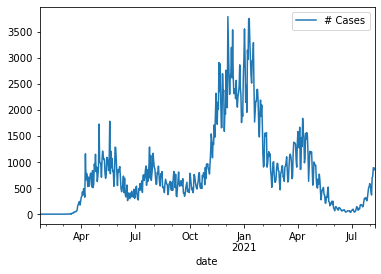

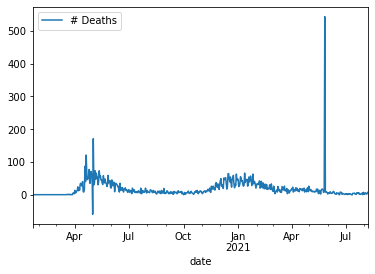

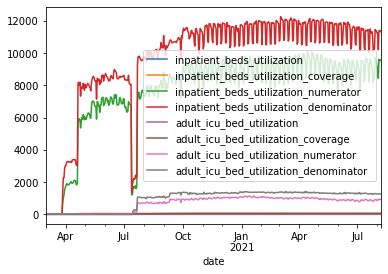

In [74]:
df_cases_temp.plot()
df_deaths_temp.plot()
df_hospital_temp.plot()

In [75]:

display(df_cases_temp.head(),df_deaths_temp.head(),df_hospital_temp.head())

,# Cases
date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0


,# Deaths
date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0


,inpatient_beds_utilization,inpatient_beds_utilization_coverage,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator
date,,,,,,,,
2020-03-01,0.666667,1.0,4.0,6.0,0.0,0.0,0.0,0.0
2020-03-02,0.666667,1.0,4.0,6.0,0.0,0.0,0.0,0.0
2020-03-03,0.666667,1.0,4.0,6.0,0.0,0.0,0.0,0.0
2020-03-04,0.666667,1.0,4.0,6.0,0.0,0.0,0.0,0.0
2020-03-05,0.666667,1.0,4.0,6.0,0.0,0.0,0.0,0.0


### Attempting Various versions of joins

In [69]:
df_state = pd.concat([df_cases_temp,df_deaths_temp,df_hospital_temp],axis=1).fillna(0)#.loc['03-2020':]
df_state

,# Cases,# Deaths,Province_State,inpatient_beds_utilization,inpatient_beds_utilization_coverage,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator
date,,,,,,,,,,,
2020-01-22,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-23,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-24,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-25,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-26,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,695.0,5.0,Maryland,0.844803,60.0,9624.0,11392.0,0.736719,60.0,943.0,1280.0
2021-08-05,729.0,2.0,Maryland,0.837001,60.0,9546.0,11405.0,0.726408,60.0,916.0,1261.0
2021-08-06,890.0,4.0,Maryland,0.841025,60.0,9586.0,11398.0,0.731073,60.0,927.0,1268.0


> ABOVE WAS TEST FOR LOOP BELOW

# FULL LOOP

In [82]:
STATES = {}
DATA_FOLDER = "./data/"

for state in unique_states:
    df_cases_temp = df_cases_ts.loc[state].sort_index().resample("D").sum().diff().fillna(0)
    df_deaths_temp = df_deaths_ts.loc[state].sort_index().resample("D").sum().diff().fillna(0)
    df_hospital_temp = df_hospitals.loc[state].drop(columns='Province_State').sort_index().resample("D").asfreq().ffill().fillna(0)
    
    df_state = pd.concat([df_cases_temp,df_deaths_temp,df_hospital_temp],axis=1).fillna(0)#.loc['03-2020':]
    df_state.to_csv(f"{DATA_FOLDER}combined_data_{state}.csv.gz",compression='gzip')   
    STATES[state] = df_state.copy()

STATES.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

In [77]:
STATES['MD']

,# Cases,# Deaths,inpatient_beds_utilization,inpatient_beds_utilization_coverage,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator
date,,,,,,,,,,
2020-01-22,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-08-04,695.0,5.0,0.844803,60.0,9624.0,11392.0,0.736719,60.0,943.0,1280.0
2021-08-05,729.0,2.0,0.837001,60.0,9546.0,11405.0,0.726408,60.0,916.0,1261.0
2021-08-06,890.0,4.0,0.841025,60.0,9586.0,11398.0,0.731073,60.0,927.0,1268.0


## Saving Data

In [78]:
import joblib
joblib.dump(STATES,'data/STATE_DICT.joblib')

['data/STATE_DICT.joblib']

In [79]:
STATES_LOADED = joblib.load('data/STATE_DICT.joblib')
STATES_LOADED['TX']

,# Cases,# Deaths,inpatient_beds_utilization,inpatient_beds_utilization_coverage,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator
date,,,,,,,,,,
2020-01-01,0.0,0.0,0.656250,2.0,42.0,64.0,0.000000,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.681818,2.0,45.0,66.0,0.000000,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.657534,2.0,48.0,73.0,0.000000,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.657534,2.0,48.0,73.0,0.000000,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.666667,2.0,36.0,54.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-08-04,13018.0,62.0,0.780201,595.0,52474.0,67257.0,0.921283,595.0,6203.0,6733.0
2021-08-05,15539.0,81.0,0.800435,595.0,53754.0,67156.0,0.916213,595.0,6058.0,6612.0
2021-08-06,23096.0,69.0,0.784588,595.0,53483.0,68167.0,0.890175,595.0,6152.0,6911.0


<AxesSubplot:xlabel='date'>

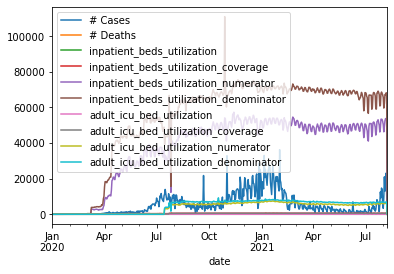

In [80]:
STATES_LOADED['TX'].plot()